## This script demonstrates how to open a Nanosurf Force Spectroscopy map and analyze the data using the DMT contact mechanics model 

In [1]:
from NSFopen.read import read

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from scipy.optimize import curve_fit

from glob import glob

filename = 'spectroscopy.nid'
filename_large = 'spectroscopy_large.nid'

In [2]:
# If USE_LARGE_MAP is True, then it will use the larger force-curve map, downloading if not already locally available 
USE_LARGE_MAP = False

In [3]:
if USE_LARGE_MAP and filename_large not in glob('*nid'):
    import urllib.request
    urllib.request.urlretrieve("https://www.dropbox.com/s/knzuh588g0uvjfi/spectroscopy_large.nid?dl=1", filename_large)
    filename = filename_large
elif USE_LARGE_MAP:
    filename = filename_large

In [4]:
# Read Date
afm = read(filename, verbose=False)
data = afm.data
param = afm.param

# probe
k = param.Tip.Prop0['Value']  # spring constant
sens = param.Tip.Sensitivity['Value']  # deflection sensitivity (if needed)

radius = 10e-9  # tip radius
nu = 0.35  # Poisson ratio (between 0.35 and 0.5)

spec_backward = data['Spec']['Backward']  # for DMT model we will use backward modulation
d = spec_backward['Deflection']  # force channel

z_signal = list(spec_backward.index)
z_chans = ['Z-Axis Sensor', 'Z-AxisSensor', 'Z-Axis']  # depending on system, Z-Axis channel may be labeled differently
available_chan = [i for i in z_signal if i in z_chans][0]

z = data['Spec']['Backward'][available_chan]  # Z-axis data

sz = int(param.Spec.maps[4])  # Map size

extent = param.Spec.maps[:4]  # X and Y physical dimensions of map

In [5]:
## Functions

# corrects for any baseline tilt
def baseline_correct(x, y, degree=1, start=0, end=0.5):
    i0 = int(np.floor(len(x) * start))
    i1 = int(np.floor(len(x) * end))

    xx = x[i0:i1]
    yy = y[i0:i1]

    p = np.polyfit(xx, yy, degree)

    y -= np.polyval(p, x)
    return y


# fits DMT model to data
def DMT(x, *param):
    elast, depth, wadh = param

    scale = 4./3. * elast * np.sqrt(radius) / (1 - nu**2)
    x = x - depth
    y = scale * np.sign(x) * np.abs(x)**(3./2.) - wadh
    return y


def DMTfit(*args, maxForce=np.Inf):
    import time
    t = time.time()
    # args are: [separation, load (force)]
    if not isinstance(args[0], list):
        args = [[ar] for ar in args]

    E = []
    for x, y in zip(*args):
        # x = x - y / spring_constant  # separation
        lenY = int(np.floor(len(y) * 0.8))
        a = min(y[lenY:])  # adhesion
    
        i0 = np.where(y == a)[0][0]  # contact point estimator index
        i1 = np.where(y > maxForce)[0]  # max force index

        if i1.size == 0:
            i1 = -1
        else:
            i1 = i1[0]

        try:
            coeff, var_matrix = curve_fit(DMT, x[i0:i1], y[i0:i1], p0=[1e9, x[i0], -a])
        except RuntimeError:
            E.append(np.nan)
        else:
            E.append(max(coeff[0], 0))

    print('Elapsed Time: %3.2f sec\n' % (time.time() - t))
    return np.array(E), (coeff, i0, i1)

In [6]:
# correct for tilt in baseline
dd = [baseline_correct(z_, d_, start=0.5, end=0.8) for z_, d_ in zip(z, d)]

# separation
zz = [zz - dd/k for dd, zz in zip(dd, z)]

# elastic modulus
Eb, _ = DMTfit(zz, dd)
Eb /= 1e9

# adhesion
adh = np.array([np.min(d) for d in dd]) * -1e9


# converts 1-D array to 2-D map and puts rows in correct order
def toMap(arr, sz):
    arr_ = np.reshape(arr, (sz, sz))
    arr_[::2] = np.fliplr(arr_[::2])
    return np.fliplr(arr_)


Ebim = toMap(Eb, sz)
Adh = toMap(adh, sz)

Elapsed Time: 0.24 sec



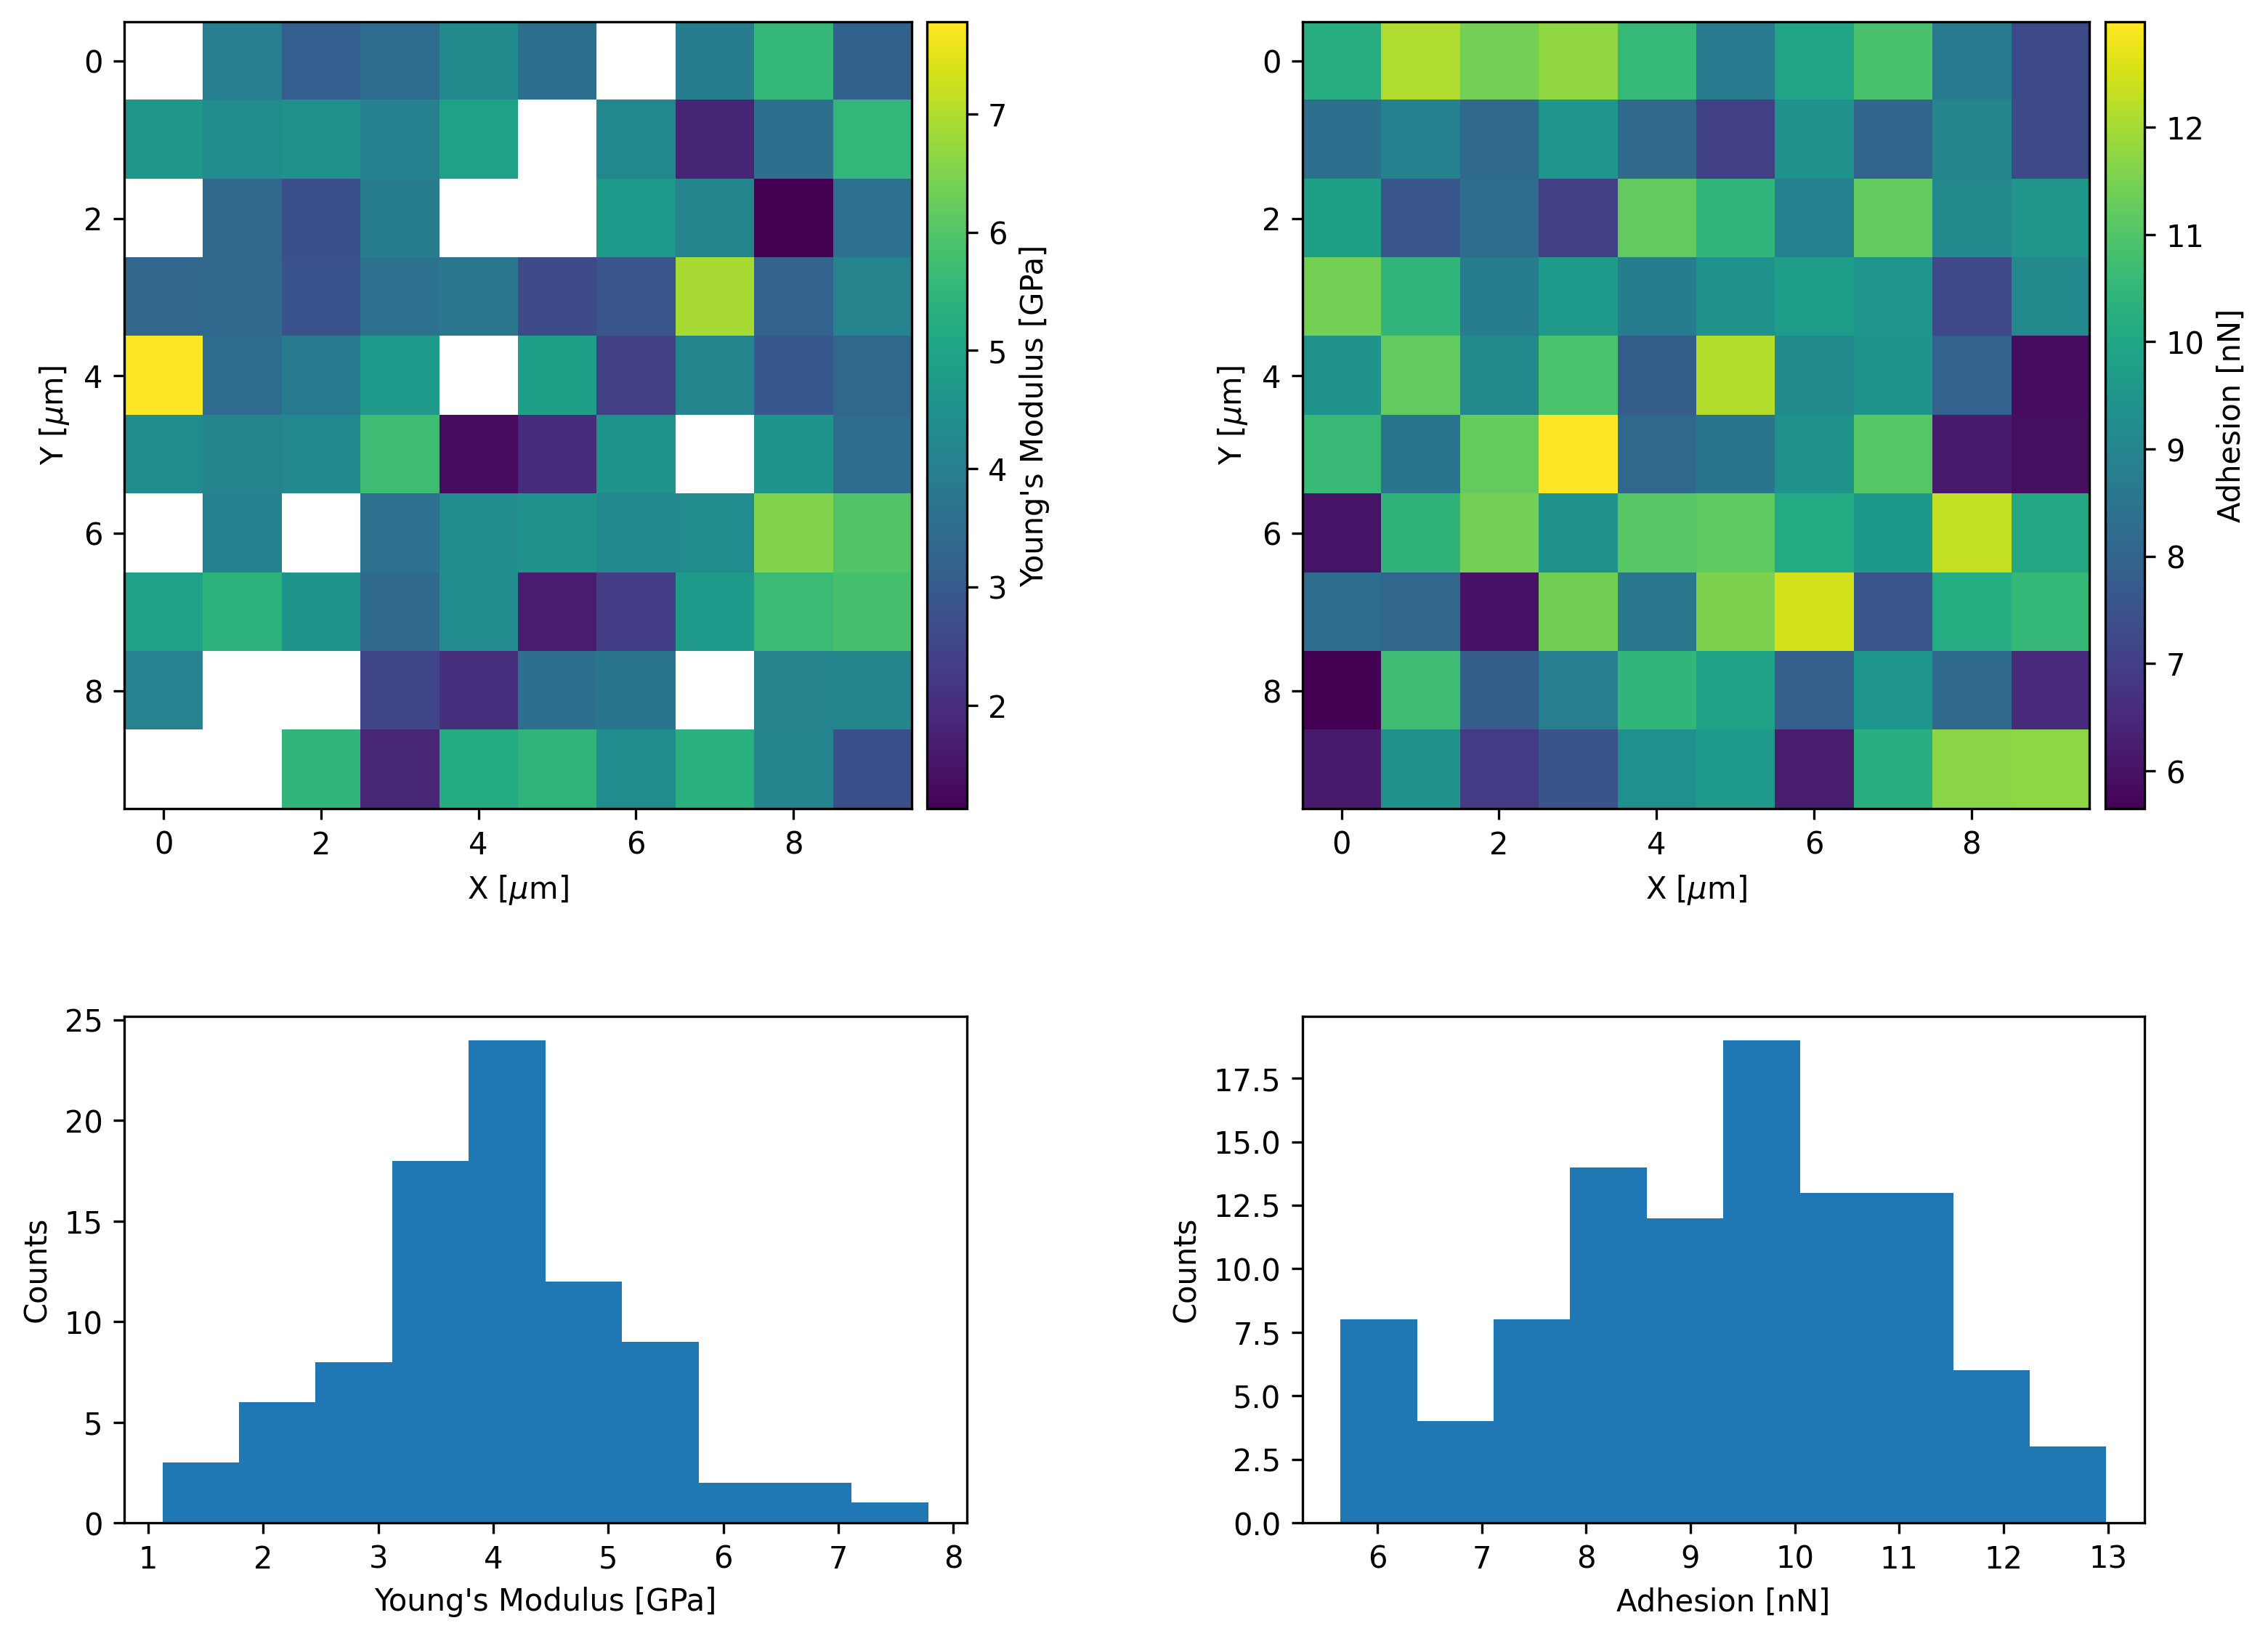

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8), gridspec_kw={'height_ratios': [2, 1]}, dpi=300)
fig.tight_layout(w_pad=8.0, h_pad=1.0)

im = ax.copy()

cmap = "afmhot"  # colormap
xlbl = 'X [$\mu$m]'
ylbl = 'Y [$\mu$m]'
zlbl = ["Young's Modulus [GPa]", "Adhesion [nN]"]

im[0, 0] = ax[0, 0].imshow(Ebim)
im[0, 1] = ax[0, 1].imshow(Adh)
im[1, 0] = ax[1, 0].hist(Eb)
im[1, 1] = ax[1, 1].hist(adh)

# sets labels and colorbar, etc.
for i in range(2):
    ax_divider = make_axes_locatable(ax[0, i])
    cax = ax_divider.append_axes("right", size="5%", pad="2%")
    cb = plt.colorbar(im[0, i], cax=cax)
    cb.set_label(zlbl[i])

    ax[0, i].set(xlabel=xlbl, ylabel=ylbl)
    ax[1, i].set(xlabel=zlbl[i], ylabel='Counts')


plt.show()